# LOGISTIC REGRESSION

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_classification

# linear models regression
from sklearn.linear_model import SGDClassifier
## metrics regression
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score, cross_validate

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [33]:
def ploting_probilities_surfaces(X, y, model, show_data=True,figsize=(10, 8)):
# def ploting_probilities_surfaces(X, y, predict_class, predict_prob, show_data=True):    
    
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))        
    space_to_plot = np.c_[xx.ravel(), yy.ravel()]
    
    Z_temp = np.argmax(model.predict_proba(space_to_plot), axis=1)        
    #Z_temp = predict_class
    Z_predict = Z_temp.reshape(xx.shape)

    Z_prob = model.predict_proba(space_to_plot)
    #Z_prob = predict_prob
    Z_prob = Z_prob[np.arange(Z_temp.shape[0]), Z_temp]
    
    Z_prob = Z_prob.reshape(xx.shape)

    fig = plt.figure()
    plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
    plt.contourf(xx, yy, Z_predict, cmap=plt.cm.Spectral, alpha=0.8)
    if show_data == True:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    fig = plt.figure()
    plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
    plt.contourf(xx, yy, Z_prob, cmap=plt.cm.Spectral, alpha=0.8)
    if show_data == True:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    
def compute_metrics_classification(y, y_pred_label, average='binary'):
    acc = accuracy_score(y, y_pred_label)
            
    presicion = precision_score(y, y_pred_label, average=average)
    recall = recall_score(y, y_pred_label, average=average)
    balanced = balanced_accuracy_score(y, y_pred_label)        
    return {'acc':acc, 'presicion':presicion, 'recall':recall, 'balanced':balanced}
    
def compute_curves(y, y_pred_prob, pos_label=1, plot=False):
    precision, recall_tpr_0, thresholds = precision_recall_curve(y, y_pred_prob[:, pos_label], pos_label=pos_label)
    print('precision-recall curve for the class ', pos_label)
    
    fpr, recall_tpr_1, thresholds = roc_curve(y, y_pred_prob[:,pos_label], pos_label=pos_label)
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
        ax[0].plot(recall_tpr_0, precision)
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Presicion')
        ax[0].set_title('Presicion - Recall curve')
        ax[1].plot(fpr, recall_tpr_1)
        ax[1].set_xlabel('1-TNR')
        ax[1].set_ylabel('Recall')
        ax[1].set_title('ROC curve')
    
    return {'pr_curve': auc(recall_tpr_0, precision), 'roc_curve':auc(fpr, recall_tpr_1)}
    
def predict_classes(y_prob):
    return np.argmax(y_prob, axis=1), np.max(y_prob, axis=1)    

def compute_presicion_recall_curve_example(y, y_prob, array_threshold):
    df_tmp = pd.DataFrame(np.vstack([y, y_prob]).T)
    df_tmp = df_tmp.sort_values(1)
    
    total_pos = df_tmp[0].sum()
    for thresh in array_threshold:
        df_pos_tmp = df_tmp[df_tmp[1]>=thresh]
        print('threshold: ', thresh)
        print('presicion: ', df_pos_tmp[0].sum()/df_pos_tmp.shape[0])
        print('recall: ', df_pos_tmp[0].sum()/total_pos)
        print()

# 1. Datos para clasificacion

## $$\{\pmb{x_i}, y_i\}_{i=1}^N~~;~\pmb{x_i}\in R^D, y_i = 1, 2,...,K$$

In [47]:
df_train, df_target = make_classification(
    n_samples = 1000,
    n_features=2,
    n_informative=1,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=42,
)

df_train = pd.DataFrame(df_train)
df_train.columns = ['fea_'+str(i) for i in range(df_train.shape[1])]

df_target = pd.DataFrame(df_target)
df_target.columns = ['target']

df_train = df_train.fillna(0.0)
df_target = df_target.fillna(0.0)
print("data size: ", df_train.shape, df_target.shape)

display(df_train.sample(10))
display(df_target.sample(10))

data size:  (1000, 2) (1000, 1)


,fea_0,fea_1
258,0.486958,-0.370011
577,0.499851,-0.622649
69,1.989798,-0.905732
944,-1.208985,-0.483886
456,-1.184009,-0.753965
131,0.913484,0.298753
670,1.578066,0.779661
743,0.491694,-0.054894
459,1.058867,-0.429302
965,1.504366,0.969457


,target
858,0
680,1
255,0
812,1
323,1
64,0
445,0
818,0
709,1
254,1


# 2. Preprocesamiento:  Feature scaling
* Remover la media (media=0) 
* Escalar la variance (var=1)

In [48]:
## Split training and test datasets.
X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_target, test_size=0.1, random_state=0)

## scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train_scaled.columns = X_train.columns

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test_scaled.columns = X_test.columns   

X_train_scaled.shape, X_test_scaled.shape

((900, 2), (100, 2))

Text(0, 0.5, 'feat_1')

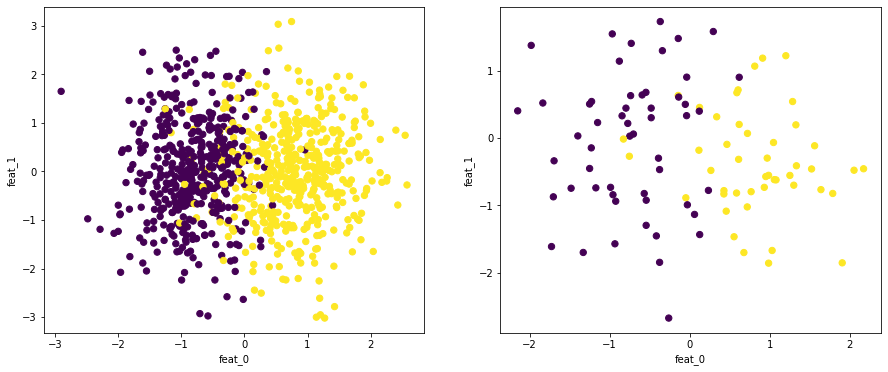

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
ax[0].scatter(X_train_scaled.values[:, 0], X_train_scaled.values[:, 1], c=Y_train.values, s=40)
ax[0].set_xlabel('feat_0')
ax[0].set_ylabel('feat_1')
ax[1].scatter(X_test_scaled.values[:, 0], X_test_scaled.values[:, 1], c=Y_test.values, s=40) #marker='s'
ax[1].set_xlabel('feat_0')
ax[1].set_ylabel('feat_1')

# 2. Model

## Approximated function: 
## $$f(\pmb{x_i}, \pmb{\theta}) = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + \theta_Dx_D \in R~;~\pmb{\theta} \in R^{D+1}$$

## $$h(\pmb{x_i}, \pmb{\theta}) = g(f(\pmb{x_i}, \pmb{\theta})) \in [0,1]$$

Donde $g$ es la sigmoid function, definida como:
### $g(z) = \frac{1}{1+e^{-z}}\in [0,1]$ 

Text(0, 0.5, 'probability')

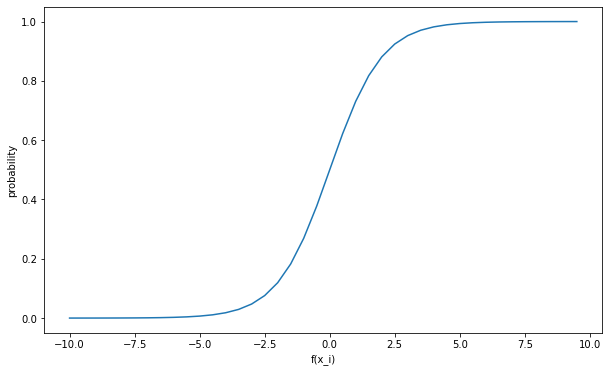

In [16]:
x_tmp = np.arange(-10, 10, 0.5)
figsize=(10, 6)
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(x_tmp, 1.0/(1.0 + np.exp(-x_tmp)))
ax.set_xlabel('f(x_i)')
ax.set_ylabel('probability')

# 3. Entrenamiento
## Loss function
## $$L(\pmb{\theta}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i\log(h(\pmb{x_i}, \pmb{\theta})) + (1 - y_i)\log(1-h(\pmb{x_i}, \pmb{\theta}))\right] \in R$$

## Encontrar $\hat{\pmb{\theta}}$ que minimize $L(\hat{\pmb{\theta}})$

## Method de learning:  Stochastic Gradient Descent (SGD) 

14
[[ 4.49349647 -0.3132128 ]]


<Figure size 432x288 with 0 Axes>

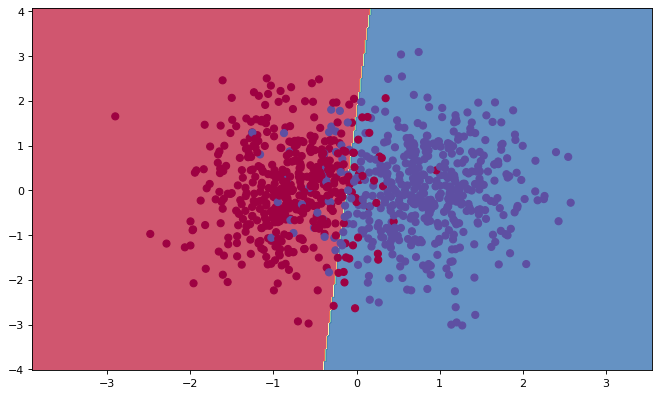

<Figure size 432x288 with 0 Axes>

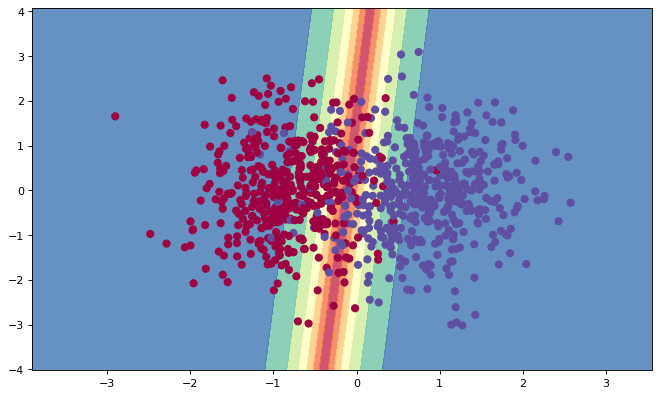

In [17]:
## Default
loss_function = 'log'
learning_rate_method = 'constant'#'invscaling'#'constant'
learning_rate = 0.1

reg_method = 'l2'
alpha = 0.0

shuffle_each_epoch = True

model = SGDClassifier(loss=loss_function, learning_rate=learning_rate_method, eta0=learning_rate, 
                      penalty=reg_method, alpha=alpha, 
                      shuffle=shuffle_each_epoch, 
                      random_state=0, max_iter=1000, tol=1e-10)
model.fit(X_train_scaled, Y_train)

y_train_pred_prob = model.predict_proba(X_train_scaled)
y_test_pred_prob = model.predict_proba(X_test_scaled)

print(model.n_iter_)
print(model.coef_)

ploting_probilities_surfaces(X_train_scaled.values, Y_train.values, model,  figsize=(10, 6))

# 4 Evaluacion 

## Metricas para clasificacion
### Accuracy
$$\frac{TP+TN}{\text{Total de datos}}$$
### Precision
Mide la abilidad del clasificador para no clasificar como positivo los ejemplos que son negativos.
 $$\frac{TP}{TP+FP}$$
### Recall, sensitivity, or true positive rate(TPR)
Mide la abilidad del clasificador para clasificar los ejemplos positivos.
 $$\frac{TP}{P} = \frac{TP}{TP+FN}$$ 
 
### Specificity or tre negative rate~(TNR) 
Mide la abilidad del clasificador para clasificar los ejemplos negativos.
 $$\frac{TN}{N} = \frac{TN}{TN+FP}$$
### Balanced accuracy
Util para medir el desempenho del clasificador en bases de datos imbalanceadas
 $$\frac{1}{2}(\frac{TP}{P} + \frac{TN}{N}) = \frac{1}{2}(\text{sensitivity} + \text{specificity})$$
### Receiver operating characteristic curve (ROC)
Muestra el desempenho de modelo, graficando $TPR$ vs false positive rate ($1-TNR$) en difierentes thresholds.

### Precision-Recall-AUC
Muestra el desempenho de modelo, precision vs recall en difierentes thresholds. Util en bases de datos imbalanceadas.

In [20]:
## compute metrics
dict_metrics_train = compute_metrics_classification(Y_train, predict_classes(y_train_pred_prob)[0])
dict_curves_train = compute_curves(Y_train, y_train_pred_prob, pos_label=1)

dict_metrics_test = compute_metrics_classification(Y_test, predict_classes(y_test_pred_prob)[0])
dict_curves_test = compute_curves(Y_test, y_test_pred_prob, pos_label=1)

df_results_metrics = pd.DataFrame([dict_metrics_train, dict_metrics_test])
df_results_metrics.index = ['metric_train', 'metric_test']

df_results_curves = pd.DataFrame([dict_curves_train, dict_curves_test])
df_results_curves.index = ['curves_train', 'curves_test']
df_results_curves

print(df_results_metrics)
print()
print(df_results_curves)

precision-recall curve for the class  1
precision-recall curve for the class  1
                   acc  presicion    recall  balanced
metric_train  0.913333   0.916849  0.912854  0.913343
metric_test   0.860000   0.796296  0.934783  0.865539

              pr_curve  roc_curve
curves_train  0.975568   0.969578
curves_test   0.965351   0.961353


precision-recall curve for the class  1


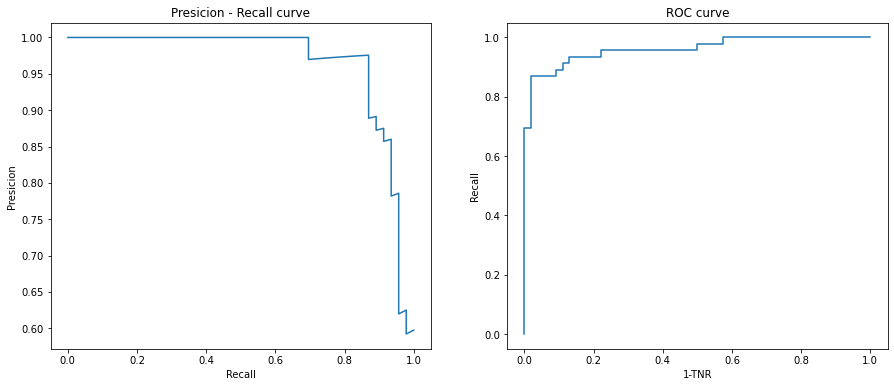

In [34]:
dict_curves_test = compute_curves(Y_test, y_test_pred_prob, pos_label=1, plot=True)

# II. Multiclass

# 1. Datos para clasificacion

In [50]:
df_train, df_target = make_classification(
    n_samples = 1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=4,
    n_clusters_per_class=1,
    random_state=42,
)

df_train = pd.DataFrame(df_train)
df_train.columns = ['fea_'+str(i) for i in range(df_train.shape[1])]

df_target = pd.DataFrame(df_target)
df_target.columns = ['target']

df_train = df_train.fillna(0.0)
df_target = df_target.fillna(0.0)

print("data size: ", df_train.shape, df_target.shape)

display(df_train.sample(10))
display(df_target.sample(10))


data size:  (1000, 2) (1000, 1)


,fea_0,fea_1
777,-1.473127,-2.619427
545,-1.450448,-2.847457
104,-0.545329,0.665287
348,0.470320,-1.159228
926,0.821223,0.897782
609,3.175188,2.766125
359,-1.061469,-1.307925
912,0.271213,0.153210
566,-1.454528,-2.621134
264,0.534053,0.573120


,target
180,2
994,1
621,0
457,0
43,1
44,2
375,1
155,1
262,2
611,2


# 2. Preprocesamiento:  Feature scaling

In [51]:
target = 'target'

X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_target, test_size=0.1, random_state=0)

## scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train_scaled.columns = X_train.columns

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test_scaled.columns = X_test.columns   

X_train_scaled.shape, X_test_scaled.shape

((900, 2), (100, 2))

Text(0, 0.5, 'feat_1')

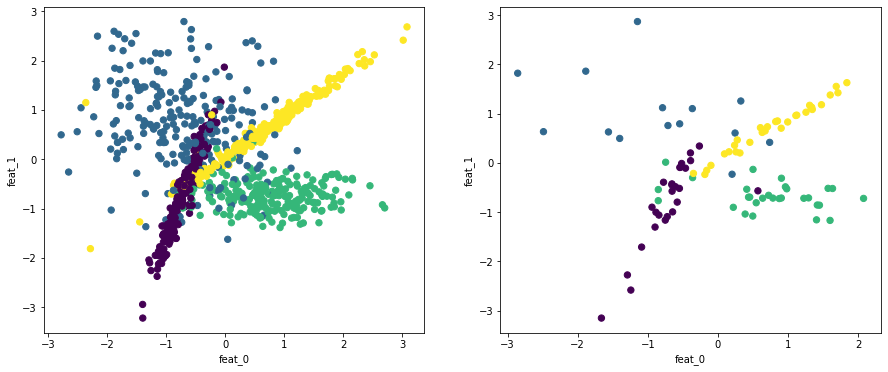

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
ax[0].scatter(X_train_scaled.values[:, 0], X_train_scaled.values[:, 1], c=Y_train.values, s=40)
ax[0].set_xlabel('feat_0')
ax[0].set_ylabel('feat_1')
ax[1].scatter(X_test_scaled.values[:, 0], X_test_scaled.values[:, 1], c=Y_test.values, s=40) #marker='s'
ax[1].set_xlabel('feat_0')
ax[1].set_ylabel('feat_1')

# 3. Entrenamiento usando SGD

586
[[-1.57082578 -1.46490215]
 [-2.13626612  2.04789568]
 [ 3.91753506 -3.67999856]
 [ 1.19379463  1.17408767]]


<Figure size 432x288 with 0 Axes>

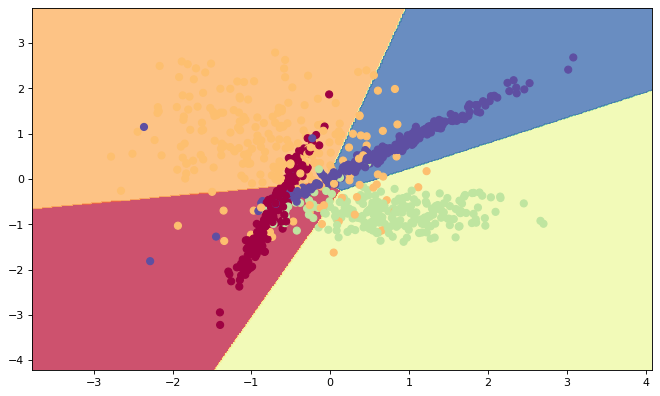

<Figure size 432x288 with 0 Axes>

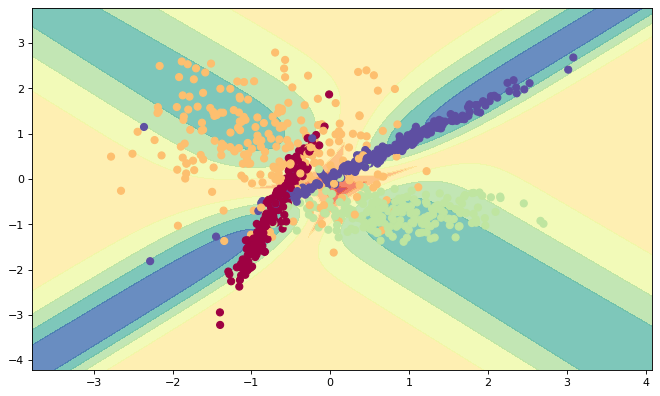

In [53]:
## Default
loss_function = 'log'
learning_rate_method = 'constant'#'invscaling'#'constant'
learning_rate = 0.001

reg_method = 'l2'
alpha = 0.0

shuffle_each_epoch = True

model = SGDClassifier(loss=loss_function, learning_rate=learning_rate_method, eta0=learning_rate, 
                      penalty=reg_method, alpha=alpha, 
                      shuffle=shuffle_each_epoch, 
                      random_state=0, max_iter=1000, tol=1e-10)
model.fit(X_train_scaled, Y_train)

y_train_pred_prob = model.predict_proba(X_train_scaled)
y_test_pred_prob = model.predict_proba(X_test_scaled)

print(model.n_iter_)
print(model.coef_)

ploting_probilities_surfaces(X_train_scaled.values, Y_train.values, model,  figsize=(10, 6))

# 4 Evaluacion 

In [54]:
## compute metrics
dict_metrics_train = compute_metrics_classification(Y_train, predict_classes(y_train_pred_prob)[0], average='macro')
dict_metrics_test = compute_metrics_classification(Y_test, predict_classes(y_test_pred_prob)[0], average='macro')

dict_curves_train = compute_curves(Y_train, y_train_pred_prob, pos_label=0)
dict_curves_test = compute_curves(Y_test, y_test_pred_prob, pos_label=0)

df_results_metrics = pd.DataFrame([dict_metrics_train, dict_metrics_test])
df_results_metrics.index = ['metric_train', 'metric_test']

df_results_curves = pd.DataFrame([dict_curves_train, dict_curves_test])
df_results_curves.index = ['curves_train', 'curves_test']
df_results_curves

print(df_results_metrics)
print()
print(df_results_curves)

precision-recall curve for the class  0
precision-recall curve for the class  0
                   acc  presicion    recall  balanced
metric_train  0.804444   0.812005  0.805201  0.805201
metric_test   0.800000   0.775560  0.784908  0.784908

              pr_curve  roc_curve
curves_train  0.764634   0.903632
curves_test   0.855696   0.943347


precision-recall curve for the class  0


{'pr_curve': 0.8556957155713576, 'roc_curve': 0.9433471933471934}

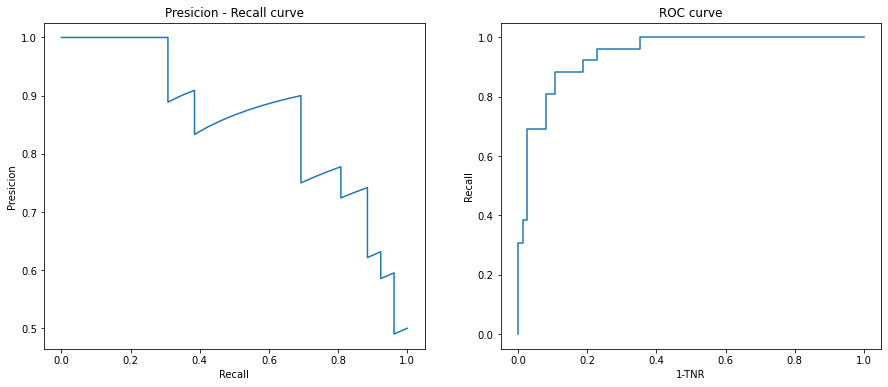

In [63]:
compute_curves(Y_test, y_test_pred_prob, pos_label=0, plot=True)

precision-recall curve for the class  1


{'pr_curve': 0.840117935398508, 'roc_curve': 0.9235880398671097}

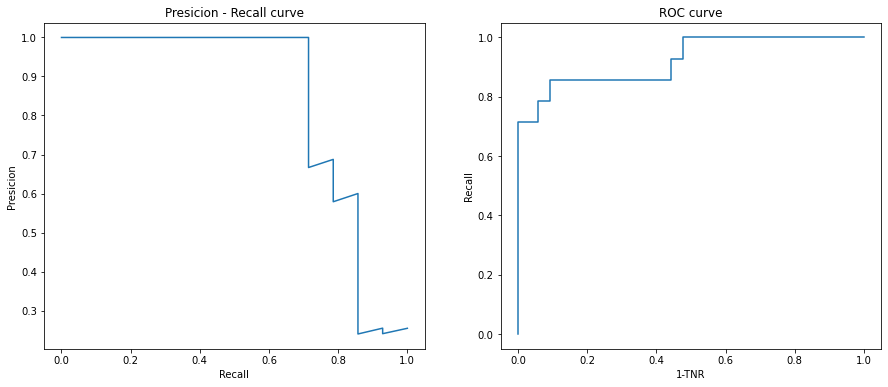

In [64]:
compute_curves(Y_test, y_test_pred_prob, pos_label=1, plot=True)

In [62]:
## another methods using average parameter
# ``'binary'``:
#         Only report results for the class specified by ``pos_label``.
#         This is applicable only if targets (``y_{true,pred}``) are binary.
# ``'micro'``:
#     Calculate metrics globally by counting the total true positives,
#     false negatives and false positives.
# ``'macro'``:
#     Calculate metrics for each label, and find their unweighted
#     mean.  This does not take label imbalance into account.
# ``'weighted'``:
#     Calculate metrics for each label, and find their average weighted
#     by support (the number of true instances for each label). This
#     alters 'macro' to account for label imbalance; it can result in an
#     F-score that is not between precision and recall.
# ``'samples'``:
#     Calculate metrics for each instance, and find their average (only
#     meaningful for multilabel classification where this differs from
#     :func:`accuracy_score`)

roc_auc_ovr_test = roc_auc_score(Y_test, y_test_pred_prob, multi_class="ovr", average="macro")
roc_auc_ovr_test 

0.9321059609369365